# Setup
Our data is in a `results/<hw-type>/*.json` structure, we need to read this into a dataframe.

In [2]:
from pathlib import Path
import json
import pandas as pd
from loguru import logger

def load_json_files(folder_path):
    all_data = []
    folder = Path(folder_path)
    
    # Iterate over all JSON files in the folder
    for file_path in folder.glob("*/*.json"):
        try:
            with file_path.open("r", encoding="utf-8") as f:
                data = json.load(f)
                
                # If data is a list of dicts, extend it
                if isinstance(data, list):
                    all_data.extend(data)
                # If data is a single dict, append it as a row
                elif isinstance(data, dict):
                    all_data.append(data)
                else:
                    logger.warning(f"Skipping {file_path.name}: Unexpected format")
        except json.JSONDecodeError:
            logger.error(f"Skipping {file_path.name}: Invalid JSON")
    
    # Convert to DataFrame
    return pd.DataFrame(all_data)

In [3]:
folder_path = "results"
df = load_json_files(folder_path)
df['1B_per_day_cost'] = 1e9/(df['throughput_req_per_sec']*3600*24)
logger.info(f"Loaded DataFrame: {len(df)} experiments")

2025-01-23 17:37:28.533 | INFO     | __main__:<module>:4 - Loaded DataFrame: 342 experiments


In [4]:
df.columns

Index(['total_requests', 'test_duration_sec', 'successful_requests',
       'avg_latency_ms', 'p95_latency_ms', 'accuracy_percentage',
       'throughput_req_per_sec', 'hw_type', 'batch_size', 'vus',
       '1B_per_day_cost'],
      dtype='object')

# Analysis

## Did we try enough VUs?
How do we know that we tried enough VUs? What if we tried a higher amount of VUs and throughput kept increasing? If thats the case then we would see a monotonicly increasing relationship between VUs and Throughput and we would need to run more tests. Lets check this out!

We can check by:
1. **Grouping data** by `hw_type` and `batch_size` to match how we generated the experiments
1. **Sorting the data** by `vus` within each group to ensure we get the data in the correct order for our check
1. **Check for monotonic increase** in `throughput_req_per_sec` flag the groups that always increase throughput as VUs increase


Note: do a sanity check with the following code to make sure that this does indeed detect if it does in-fact detect the series you expect.
```python
df_filtered = df[df['vus'] <= 256]`
grouped = df_filtered.groupby(['hw_type', 'batch_size'])
```


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Grouping by 'hw_type' and 'batch_size'
grouped = df.groupby(['hw_type', 'batch_size'])

# Identifying monotonically increasing series for throughput_req_per_sec as vus increases
monotonic_series = {}
for (hw_type, batch_size), group in grouped:
    group_sorted = group.sort_values('vus')  # Ensure sorted order by vus
    if group_sorted['throughput_req_per_sec'].is_monotonic_increasing:
        monotonic_series[(hw_type, batch_size)] = group_sorted[['vus', 'throughput_req_per_sec']]

# Plotting the identified monotonically increasing series
for (hw_type, batch_size), data in monotonic_series.items():
    plt.figure(figsize=(8, 5))
    plt.plot(data['vus'], data['throughput_req_per_sec'], marker='o', linestyle='-')
    plt.xlabel('Virtual Users (VUs)')
    plt.ylabel('Throughput (Requests per Sec)')
    plt.title(f'Throughput Trend for HW: {hw_type}, Batch: {batch_size}')
    plt.grid(True)
    plt.show()

# Display the results in a DataFrame
monotonic_df = pd.DataFrame(
    [(hw, batch) for (hw, batch) in monotonic_series.keys()],
    columns=['hw_type', 'batch_size']
)

print(monotonic_df)


Empty DataFrame
Columns: [hw_type, batch_size]
Index: []


## Are we accurate enough?
We shouldn't expect to see significant changes in accuracy. We should see a pretty tight distribution, but there might be some deviation since for lower VUs we wont have as many samples of our `10_000` that we saw with higher VUs.

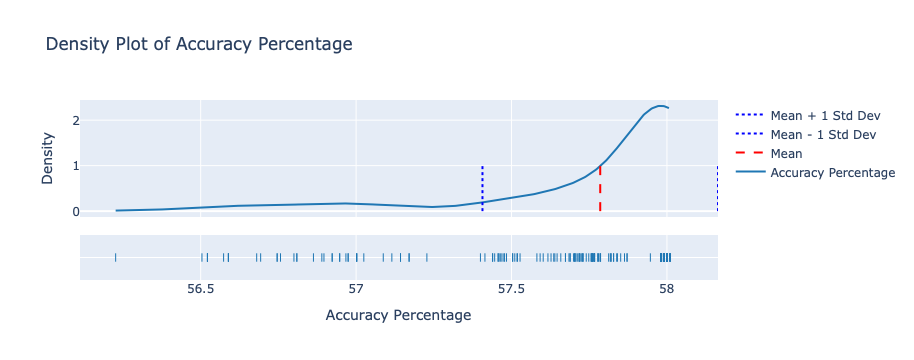

In [8]:
import plotly.figure_factory as ff

mean_accuracy = df["accuracy_percentage"].mean()
std_dev_accuracy = df["accuracy_percentage"].std()

# Create a distribution plot (outline instead of bins)
fig = ff.create_distplot([df['accuracy_percentage']], ['Accuracy Percentage'], show_hist=False, show_rug=True)

# Add mean and standard deviation lines
fig.add_trace(go.Scatter(x=[mean_accuracy, mean_accuracy], y=[0, 1],
                         mode="lines", name="Mean", line=dict(color="red", dash="dash")))

fig.add_trace(go.Scatter(x=[mean_accuracy - std_dev_accuracy, mean_accuracy - std_dev_accuracy],
                         y=[0, 1],
                         mode="lines", name="Mean - 1 Std Dev", line=dict(color="blue", dash="dot")))

fig.add_trace(go.Scatter(x=[mean_accuracy + std_dev_accuracy, mean_accuracy + std_dev_accuracy],
                         y=[0, 1],
                         mode="lines", name="Mean + 1 Std Dev", line=dict(color="blue", dash="dot")))

# Update layout
fig.update_layout(title="Density Plot of Accuracy Percentage",
                  xaxis_title="Accuracy Percentage",
                  yaxis_title="Density",
                  showlegend=True)

# Show figure
fig.show()

In [9]:
# Display statistics
stats_df = pd.DataFrame({'Statistic': ['Mean', 'Standard Deviation'],
                         'Value': [mean_accuracy, std_dev_accuracy]})
stats_df

Statistic      Value
0                Mean  57.785414
1  Standard Deviation   0.378881

Here we can see some deviation with a large z-score, but overall its not that big of an absolute devation. These also occur when we have relatively low `total_requests` which makes sense. 

We should worry more if we see major `absolute_deviation` with higher `total_requests`.

In [10]:
from scipy.stats import zscore

# Calculate absolute deviation from the mean
df['absolute_deviation'] = abs(df['accuracy_percentage'] - mean_accuracy)

# Calculate z-score
df['z_score'] = zscore(df['accuracy_percentage'])

# Get the top 5 outliers with the highest absolute deviation
top_outliers = df.nlargest(5, 'absolute_deviation')[['vus', 'batch_size', 'total_requests', 'accuracy_percentage', 'absolute_deviation', 'z_score']]
top_outliers['accuracy_percentage'] = top_outliers['accuracy_percentage'].round(2)
top_outliers['absolute_deviation'] = top_outliers['absolute_deviation'].round(2)
top_outliers['z_score'] = top_outliers['z_score'].round(2)

top_outliers

vus  batch_size  total_requests  accuracy_percentage  absolute_deviation  \
164    1           8             265                56.23                1.56   
327    1           8             246                56.50                1.28   
112    1         512             253                56.52                1.26   
255    1         512             253                56.52                1.26   
290    1         256             253                56.52                1.26   

     z_score  
164    -4.12  
327    -3.39  
112    -3.34  
255    -3.34  
290    -3.34

## Cost vs Latency

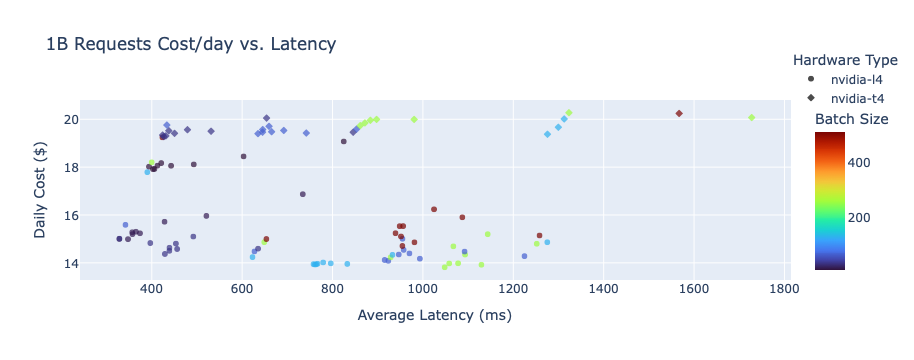

In [25]:
import plotly.express as px

fig = px.scatter(df.nsmallest(100, '1B_per_day_cost'), 
                 x='avg_latency_ms', 
                 y='1B_per_day_cost', 
                 symbol='hw_type', 
                 color='batch_size',  # Use batch size directly
                 color_continuous_scale='Turbo',  # Improved color scheme
                 opacity=0.7, 
                 title='1B Requests Cost/day vs. Latency',
                 labels={'avg_latency_ms': 'Average Latency (ms)',
                         '1B_per_day_cost': 'Daily Cost ($)',
                         'hw_type': 'Hardware Type',
                         'batch_size': 'Batch Size',
                        },
                 hover_data=['vus', 'batch_size', 'throughput_req_per_sec']
                )

fig.update_layout(
    legend=dict(
        x=1,  # Moves legend to the right
        y=1.3,  # Aligns legend at the top
        title="Hardware Type"
    )
)

fig.show()

In [38]:
df.columns

Index(['total_requests', 'test_duration_sec', 'successful_requests',
       'avg_latency_ms', 'p95_latency_ms', 'accuracy_percentage',
       'throughput_req_per_sec', 'hw_type', 'batch_size', 'vus',
       '1B_per_day_cost', 'absolute_deviation', 'z_score', 'vus_log'],
      dtype='object')

In [48]:
df.sort_values(by="1B_per_day_cost", ascending=True).iloc[:75][['hw_type', 'batch_size', 'vus']]['vus'].min()

np.int64(256)

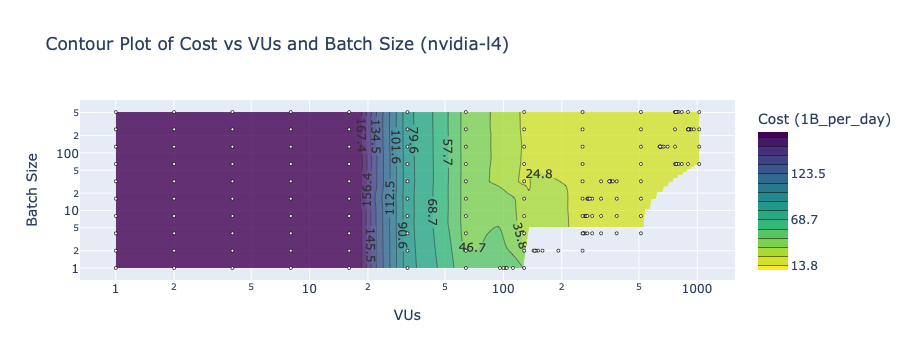

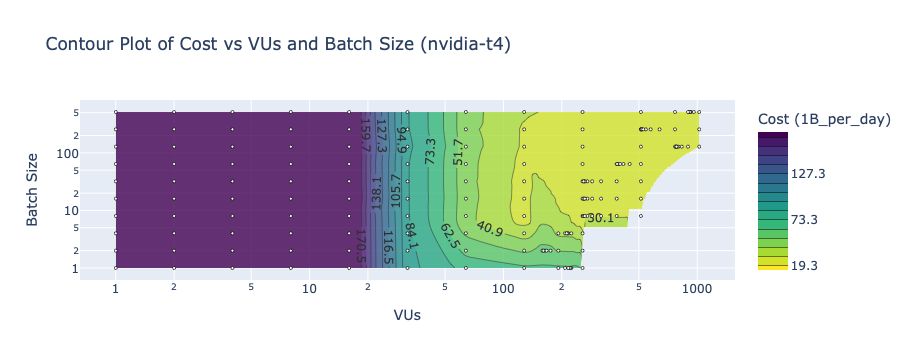

In [90]:
import plotly.graph_objects as go
import scipy.interpolate
import numpy as np
import pandas as pd

# Load your DataFrame (ensure it contains 'vus', 'batch_size', '1B_per_day_cost', and 'hw_type')

for hw in df["hw_type"].unique():
    df_hw = df[df["hw_type"] == hw]

    # Define percentile bins for cost
    percentiles = np.linspace(0, 75, 15)  # Define bins using percentiles
    cost_bins = np.percentile(df_hw["1B_per_day_cost"], percentiles)  # Compute cost bins

    # Create grid for interpolation (Now X = VUs, Y = batch_size)
    grid_x_real, grid_y_real = np.meshgrid(
        np.linspace(df_hw["vus"].min(), df_hw["vus"].max(), 100),  # X-axis is now VUs
        np.linspace(df_hw["batch_size"].min(), df_hw["batch_size"].max(), 100)  # Y-axis is now batch_size
    )

    # Interpolate cost data (Now X = VUs, Y = batch_size)
    grid_z_real = scipy.interpolate.griddata(
        (df_hw["vus"], df_hw["batch_size"]),  # Order remains the same
        df_hw["1B_per_day_cost"],
        (grid_x_real, grid_y_real),  # Adjusted grid order
        method='linear'  # Linear interpolation for smoother transitions
    )

    # Create Plotly figure
    fig_hw = go.Figure()

    # Contour plot with percentile-based cost bins
    fig_hw.add_trace(
        go.Contour(
            z=grid_z_real,
            x=np.linspace(df_hw["vus"].min(), df_hw["vus"].max(), 100),  # X-axis is now VUs
            y=np.linspace(df_hw["batch_size"].min(), df_hw["batch_size"].max(), 100),  # Y-axis is now batch_size
            colorscale="viridis_r",
            contours=dict(
                start=cost_bins[0],
                end=cost_bins[-1],
                size=np.diff(cost_bins).mean(),  # Uses percentile bins
                showlabels=True
            ),
            colorbar=dict(title="Cost (1B_per_day)"),
            hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{z}",
            opacity=0.8  # Reduce opacity to make scatter points stand out
        )
    )

    # Scatter plot of actual data points
    fig_hw.add_trace(
        go.Scatter(
            x=df_hw["vus"],  # X-axis is now VUs
            y=df_hw["batch_size"],  # Y-axis is now batch_size
            mode="markers",
            marker=dict(size=3, color="white", line=dict(width=0.5, color="black")),  
            name="Real Data Points",
            hovertemplate="VUs: %{x}<br>Batch Size: %{y}<br>Cost: %{text}",
            text=df_hw["1B_per_day_cost"],
            showlegend=False
        )
    )

    fig_hw.update_layout(
        title=f"Contour Plot of Cost vs VUs and Batch Size ({hw})",
        xaxis_title="VUs",
        yaxis_title="Batch Size",
        xaxis_type="log",
        yaxis_type="log"
    )

    fig_hw.show()
